In [111]:
# settings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import mpl

from numpy.fft import fft,ifft,fftshift,ifftshift
from matplotlib import cm
from scipy.special import jv
import random
import time

import os
import sys
from numba import jit

# mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体
mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS']
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['font.size'] = 14  #设置字体大小，全局有效
plt.rcParams['agg.path.chunksize'] = 120

c0=299792458
h=6.62607015e-34 # 普朗克常量
hbar=h/(2*np.pi) # 约化普朗克常量
k_B=1.380649e-23 # 玻尔兹曼常量


In [112]:
# Lasing parameters of Erbium
N = 3.959e26 # Er离子浓度: m^-3
sigma_sa = 4.03e-25 # signal的吸收截面: m^2
sigma_se = 6.76e-25 # signal的发射截面: m^2
sigma_pa = 4.48e-25 # pump的吸收截面: m^2
sigma_pe = 1.07e-25 # pump的发射截面: m^2
tau_g = 10e-3 # 上能级寿命: s
lambda_s = 1550e-9 # signal波长: m
lambda_p = 1480e-9 # pump波长: m
lambda_g = 30e-9 # gain带宽: m
nu_s = c0 / lambda_s
nu_p = c0 / lambda_p
omega_p = 2 * np.pi * nu_p
omega_s = 2 * np.pi * nu_s
A_s = 0.9e-12 # signal有效模面积: m^2
A_p = 0.9e-12 # pump有效模面积: m^2
T = 300 # 温度: K
Gamma_s = 0.9 # signal与Er离子的模斑交叠系数
Gamma_p = 0.9 # pump与Er离子的模斑交叠系数
beta = np.exp(-1.0 / k_B / T * h * c0 * (1.0/lambda_p - 1.0/lambda_s))


In [113]:
# key parameters
the_FSR = 25e9
the_M = 1.0
the_P_pump = 50e-3


In [114]:
#! Micro-cavity parameters
beta2 = -58e-27 # 色散: s^2/m
n2 = 1.8e-19 # LiNbO3的Kerr系数: m^2/W
FSR = the_FSR
L_d = 5e-3 * 25e9 / FSR # 腔长: m
T_R = 1.0 / FSR # roundtrip time: s
omega_m = 2 * np.pi * FSR
Omega_g = 2 * np.pi * c0 / lambda_s**2 * lambda_g # 增益的半高半宽: rad
Q_s_in = 2e6 # 腔的本征Q
Q_s_ex = 2e6 # 腔的耦合Q
Q_s = 1.0 / (1.0/Q_s_in + 1.0/Q_s_ex) # 腔的总Q
Q_s = 0.3e6
Q_p_in = 2e6 # 腔的本征Q, pump处
Q_p_ex = 2e6
Q_p = 1.0 / (1.0/Q_p_in + 1.0/Q_p_ex)
Q_p = 0.2e6
D = -0.5 * beta2 * L_d
delta_kerr = n2 * omega_s * L_d / (c0 * A_s) # Kerr效应的系数δ
phi_opt = 0.0 # pump光的失谐
gamma = 0 # 电光梳在波导和谐振腔耦合处的损耗
k = 2 * np.pi * omega_p / omega_m / Q_p_ex # 电光梳在波导和谐振腔耦合处的耦合效率，功率
total_loss = 2 * np.pi * omega_p / omega_m / Q_p # 电光梳的腔总损耗，功率
l_p_in = np.pi * omega_p / omega_m / Q_p_in
l_s = np.pi * omega_s / omega_m / Q_s # Haus方程中的loss,包含signal光由于本征/耦合的损耗

mode_number = 2**10

t = np.linspace(-T_R/2, T_R/2 - T_R/mode_number, mode_number)
delta_t = T_R / mode_number
q = np.linspace(-mode_number//2, mode_number//2 - 1, mode_number)
xs = np.linspace(-np.pi, np.pi - 2*np.pi/mode_number, mode_number)

phi_disp = ifftshift(2e-5 * q**2) # pump光的色散
q_ishift = ifftshift(q)

M = the_M
P_pump = the_P_pump
prompt = "P_pump=" + str(P_pump*1000) + "mW" + ",M=" + str(M) + ",FSR=" + str(FSR/1e9) + "GHz"
print("prompt:", prompt)


# IO
directory_name = time.strftime("%Y%m%d:%H%M:%S", time.localtime())
print(prompt)


# 时间normalize到T_R
scale = 1 # 每保存一次运行scale个roundtrip time
steps = 1
eta = 1 / steps
save_round = 100000
plot_round = min(save_round // 6, 50000)
begin_to_save = 0


# 记录此时所有的变量
print("steps = " + str(steps))
print("save_round = " + str(save_round))


#! Roundtrip phase model for EO comb
@jit(nopython=True)
def roundtrip_evolution_for_EO_comb(E_np, loss):
    '''一圈之后pump电场的变化,电场normalize到光功率的平方根'''
    spectrum = fft(E_np)
    phi_micro = 0.0 # 电光调制频率的失谐
    new_spectrum = spectrum * np.exp(-1.0j*(phi_opt+phi_micro+phi_disp))
    field = ifft(new_spectrum)
    new_field = \
        np.exp(-loss) \
            * (np.sqrt(1-k) * field + 1.0j * np.sqrt(k * P_pump) * np.exp(-1.0j*phi_opt)) \
            * np.exp(1.0j*M*np.cos(omega_m*t))
    return new_field


#! Roundtrip phase model for signal
@jit(nopython=True)
def roundtrip_evolution_for_signal(A, loss, gain, delta_kerr, steps, M, D, _xs):
    '''一圈之后signal电场的变化,电场normalize到光功率的平方根'''
    eta = 1 / steps
    for _k in range(steps): # _k循环steps次，演化一个roundtrip time，因为dT=1/steps
        # LLE 演化
        A = A * np.exp((-loss + 1.0j*delta_kerr*np.abs(A**2) + 1.0j*M*np.cos(_xs)) * eta)
        A_spectrum = fft(A)
        r = -1.0j * D * (q_ishift*omega_m)**2 + gain/(1+(omega_m/Omega_g*q_ishift)**2)
        A_spectrum = A_spectrum*np.exp(eta*r)
    return A_spectrum

@jit(nopython=True)
def next_g(g, g_0, signal_power, p_sat, _tau_prime):
    g_limit = g_0 / (1 + signal_power / p_sat)
    # return g_limit
    delta_g =  (g_0 - (1 + signal_power / p_sat) * g) * T_R / _tau_prime
    if (delta_g == 0):
        return g
    if (delta_g > 0 and g + delta_g > g_limit):
        return g_limit
    elif (delta_g < 0 and g + delta_g < g_limit):
        return g_limit
    else:
        return g + delta_g


@jit(nopython=True)
def ASE(A_spectrum, g, l):
    # return A_spectrum
    N_2 = (N + (2 * g) / (Gamma_s * sigma_sa * L_d)) / (1 + beta + sigma_se / sigma_sa)
    alpha = max(h * FSR * sigma_se * Gamma_s * N_2 * L_d * (np.exp(2*g) - 1) / (g - l), 0)
    ase_spectrum = np.sqrt(alpha * (nu_s + FSR * q_ishift))
    ase_spectrum_modified = ase_spectrum * np.array([np.exp(1.0j * random.random() * 2 * np.pi) for i in range(mode_number)])
    A_spectrum += ase_spectrum_modified
    ase_power = np.sum(np.abs(ase_spectrum_modified)**2) / mode_number * delta_t / T_R
    # sys.stderr.write(str(ase_power))
    return A_spectrum, ase_power


@jit(nopython=True)
def parameter_calculation(E_p, A, g):
    pump_power = np.sum(np.abs(E_p)**2) * delta_t / T_R
    signal_power = np.sum(np.abs(A)**2) * delta_t / T_R
    rsignal_power = signal_power
    tau_prime = (1 + beta) / (1 / tau_g + (1 + beta + beta * sigma_pe / sigma_pa) * pump_power * sigma_pa * Gamma_p / h / nu_p / A_p)
    p_sat = h * nu_s * A_s / (Gamma_s * tau_prime * (sigma_sa + sigma_se / (1 + beta)))
    g_0 = 0.5 * Gamma_s * L_d * sigma_se * N * tau_prime / (1 + beta) * ((1 - sigma_sa / sigma_se * beta * sigma_pe / sigma_pa) * sigma_pa * Gamma_p / h / nu_p / A_p * pump_power - sigma_sa / sigma_se / tau_g)
    g_p = 0.5 * Gamma_p * L_d * N * (beta * sigma_pe * sigma_sa - sigma_pa * sigma_se) / (sigma_se + sigma_sa * (1 + beta)) + (sigma_pe * beta + sigma_pa * (1 + beta)) / (sigma_se * beta + sigma_sa * (1 + beta)) * g
    l_p = l_p_in - g_p
    return pump_power, signal_power, rsignal_power, tau_prime, p_sat, g_0, l_p


def data_save(A_save, g_save, E_p_save, A, g, E_p):
    A_save.append(A)
    g_save.append(g)
    E_p_save.append(E_p)


# simulation of mode locking
A_save = []
g_save = []
E_p_save = []
# E_0p=1.0j*total_loss*np.sqrt(k)/(1.0-total_loss*np.sqrt(1-k)*np.exp(-1.0j*phi_opt))*np.sqrt(P_pump)*np.exp(-1.0j*phi_opt)*np.exp(-1.0j * omega_p * t) # 初始的pump光场：未加电光调制，腔内为CW场，泵浦与耗散相平衡
E_0p = np.zeros(mode_number) + 1.0j * np.sqrt(k * P_pump) / (np.exp(total_loss/2) - np.sqrt(1-k))
A_0 = np.array([random.random() * np.exp(1.0j*random.random()*2*np.pi) for i in range(mode_number)])*1e-3 # 初始signal光场为噪声
pump_power, signal_power, rsignal_power, tau_prime, p_sat, g_0, l_p = parameter_calculation(E_0p, A_0, 0)
ase_power = 0
print("total_loss = " + str(total_loss))
print("g_0 = ", g_0)
print("tau_prime = ", tau_prime)
print("p_sat = ", p_sat)

E_p = E_0p
A = A_0
g = g_0
g = l_s

"""main loop begin"""
for _i in range(save_round):
    sys.stderr.write("process: %.2f%%, g = %f, pump_power = %f, signal_power = %f, p_sat = %f, l_p = %f, l_s = %f, ase_power = %f(nW)      \r" % (_i/save_round * 100, g, pump_power, signal_power, p_sat, l_p, l_s, ase_power * 1e9))
    for _j in range(scale):
        pump_power, signal_power, rsignal_power, tau_prime, p_sat, g_0, l_p = parameter_calculation(E_p, A, g)
        g = next_g(g, g_0, signal_power, p_sat, tau_prime)
        A_spectrum = roundtrip_evolution_for_signal(A, l_s, g, delta_kerr, steps, M, D, xs)
        A_spectrum, ase_power = ASE(A_spectrum, g, l_s)
        A = ifft(A_spectrum)
        E_p = roundtrip_evolution_for_EO_comb(E_p, l_p)
    if _i >= save_round - plot_round:
        data_save(A_save, g_save, E_p_save, A, g, E_p)
"""main loop end"""


A_save = np.array(A_save).T
g_save = np.array(g_save)
E_p_save = np.array(E_p_save).T
T = np.array(range(save_round - plot_round, save_round)) * scale
T_G = np.array(range(save_round - plot_round, save_round)) * scale
x,y=np.meshgrid(T,t)


prompt: P_pump=50.0mW,M=1.0,FSR=25.0GHz
P_pump=50.0mW,M=1.0,FSR=25.0GHz
steps = 1
save_round = 100000
total_loss = 0.254547509095791
g_0 =  0.45223690159556634
tau_prime =  4.9684892751996305e-06
p_sat =  0.027096026582629863


max spectrum_p_log = 16.763555772386653
-16.522793347666028
EO comb peak power = 35.341274899562364 mW
EO comb average power = 6.199788514440995 mW
从腔内输出的signal pulse: 
时域上单个pulse峰值功率(mW): 166.3837195002748
时域上单个pulse平均能量(J): 8.492669782318682e-14
时域上单个pulse平均功率(mW): 2.123167445579671
相对于泵浦光的转换效率(%): 4.246334891159342
pump光(功率)的耦合损耗: k= 0.025454750909579098
pump光(功率)的本征损耗: α= 0.0254547509095791
pump光(功率)的总损耗: l_s= 0.254547509095791
signal光(功率)的耦合损耗: k'= 0.024305181513662618
signal光(功率)的本征损耗: α'= 0.024305181513662618
signal光(功率)的总损耗: l_s'= 0.16203454342441748


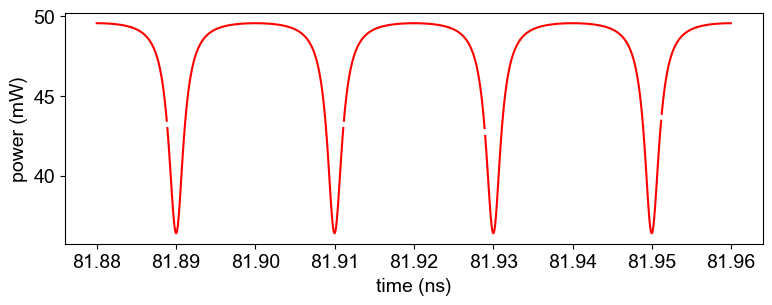

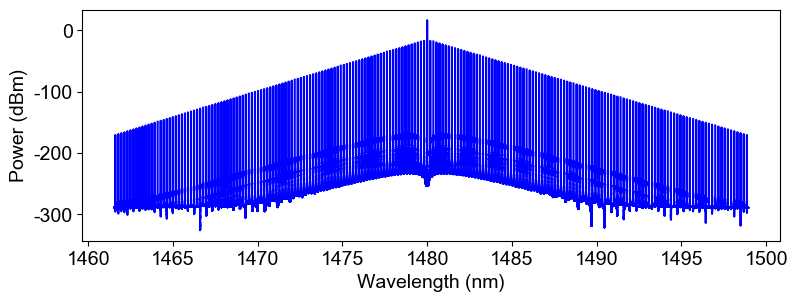

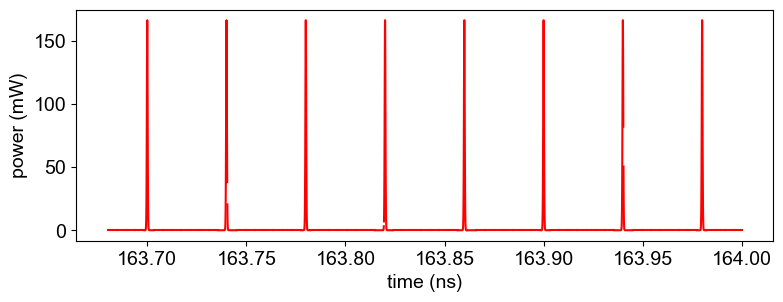

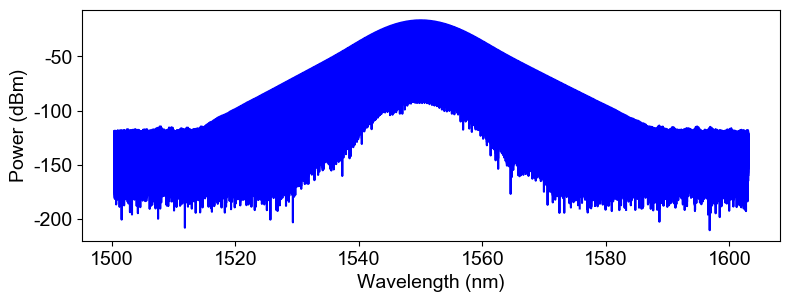

In [115]:
# 以下是绘图部分

%matplotlib inline
# %matplotlib widget

plt.cla()
plt.clf()
plt.close()


time_domain_p = E_p_save[:, -1 - mode_number * 4 : -1].T.ravel()
time_domain_p = time_domain_p * np.sqrt(k)*1.0j+np.sqrt(1-2*np.pi*omega_p/Q_p_ex/omega_m)*np.sqrt(P_pump)
spectrum_p=fftshift(fft(time_domain_p*delta_t))
spectrum_p_log=10*np.log10(np.abs(spectrum_p/T_R/(len(time_domain_p)/mode_number))**2/1e-3)
freq_list_p = np.linspace(c0/lambda_p - mode_number/2*FSR, c0/lambda_p + mode_number/2*FSR, len(time_domain_p))
lamb_list_p = c0 / freq_list_p

t_center_p=len(time_domain_p)//2
t_range_p=len(time_domain_p)//mode_number//4
fig_1 = plt.figure("Output EO comb pulse train",figsize=(9,3),dpi=100)
ax_1_1 = fig_1.add_subplot(111)
ax_1_1.plot((np.array(range(len(time_domain_p)))*T_R*1e9/mode_number)[t_center_p-t_range_p:t_center_p+t_range_p],(1e3*np.abs(time_domain_p)**2)[t_center_p-t_range_p:t_center_p+t_range_p],color="red")
ax_1_1.set_xlabel("time (ns)")
ax_1_1.set_ylabel("power (mW)")
# plt.show()

k_center_p=len(spectrum_p)//2
k_range_p=len(spectrum_p)//10
fig_2 = plt.figure("Spectrum of pump",figsize=(9,3),dpi=100)
ax_2_1 = fig_2.add_subplot(111)
ax_2_1.plot(1e9*lamb_list_p[k_center_p-k_range_p:k_center_p+k_range_p],spectrum_p_log[k_center_p-k_range_p:k_center_p+k_range_p],color="blue")
ax_2_1.set_xlabel("Wavelength (nm)")
ax_2_1.set_ylabel("Power (dBm)")
# plt.show()
print("max spectrum_p_log =", max(spectrum_p_log))


time_domain = A_save[:, -1 - mode_number * 8 : -1].T.ravel()
time_domain=np.array(time_domain)*np.sqrt(2*np.pi*omega_s/Q_s/omega_m)
spectrum=fftshift(fft(time_domain*delta_t))
spectrum_log=10*np.log10(np.abs(spectrum/T_R/(len(time_domain)/mode_number))**2/1e-3)
freq_list=np.linspace(c0/lambda_s-mode_number/2*FSR,c0/lambda_s+mode_number/2*FSR,len(time_domain))
lamb_list=c0/freq_list

t_center=len(time_domain)//2
t_range=len(time_domain)//mode_number//2
fig_3 = plt.figure("Pulse Train of signal",figsize=(9,3),dpi=100)
ax_3_1 = fig_3.add_subplot(111)
ax_3_1.plot((np.array(range(len(time_domain)))*T_R*1e9/mode_number)[t_center-t_range:t_center+t_range],(1e3*np.abs(time_domain)**2)[t_center-t_range:t_center+t_range],color="red")
ax_3_1.set_xlabel("time (ns)")
ax_3_1.set_ylabel("power (mW)")
# plt.show()

k_center=len(spectrum)//2
k_range=len(spectrum)//4

fig_4 = plt.figure("Spectrum of signal",figsize=(9,3),dpi=100)
ax_4_1 = fig_4.add_subplot(111)
ax_4_1.plot(1e9*lamb_list[k_center-k_range:k_center+k_range],spectrum_log[k_center-k_range:k_center+k_range],color="blue")
ax_4_1.set_xlabel("Wavelength (nm)")
ax_4_1.set_ylabel("Power (dBm)")
# plt.show()
print(max(spectrum_log))

signal_average_power=np.sum(np.abs(A_save[:,-1])**2)/T_R*delta_t
EO_comb_average_power=np.sum(np.abs(E_p_save[:,-1])**2)/T_R*delta_t
# print(signal_average_power)
# print(EO_comb_average_power)
print("EO comb peak power = "+str(np.max(np.abs(E_p_save[:,-1])**2)*1e3)+" mW")
print("EO comb average power = "+str(EO_comb_average_power*1e3)+" mW")
print("从腔内输出的signal pulse: ")
print("时域上单个pulse峰值功率(mW): ",end="")
print(np.max(np.abs(time_domain)**2)*1e3)
print("时域上单个pulse平均能量(J): ",end="")
print(np.sum(np.abs(time_domain)**2)*delta_t/(len(time_domain)/mode_number))
print("时域上单个pulse平均功率(mW): ",end="")
print(np.sum(np.abs(time_domain)**2)*delta_t/(len(time_domain)/mode_number)/T_R*1e3)
# print("频域上单个pulse平均能量(J): ",end="")
# print(np.sum(np.abs(spectrum)**2)*(freq_list[-1]-freq_list[-2])/(len(time_domain)/mode_number))
print("相对于泵浦光的转换效率(%): ",end="")
print(np.sum(np.abs(time_domain)**2)*delta_t/(len(time_domain)/mode_number)/T_R/P_pump*1e2)

# 本次运行的相关信息
print("pump光(功率)的耦合损耗: k= "+str(k))
print("pump光(功率)的本征损耗: α= "+str(2*np.pi*omega_p/Q_p_in/omega_m))
print("pump光(功率)的总损耗: l_s= "+str(total_loss))
print("signal光(功率)的耦合损耗: k'= "+str(2*np.pi*omega_s/Q_s_ex/omega_m))
print("signal光(功率)的本征损耗: α'= "+str(2*np.pi*omega_s/Q_s_in/omega_m))
print("signal光(功率)的总损耗: l_s'= "+str(2*np.pi*omega_s/Q_s/omega_m))

# fig_5 = plt.figure("Gain",figsize=(9,3),dpi=100)
# ax_5_1 = fig_5.add_subplot(111)
# ax_5_1.plot(T_G[::],g_save[::],color="red",label="Gain")
# # plt.plot(T_G[::],[l_s for i in range(0, save_round)],color="blue",label="Loss")
# ax_5_1.legend()
# ax_5_1.set_xlabel("Roundtrip Time")
# ax_5_1.set_ylabel("Gain")
# # plt.show()

# fig_6 = plt.figure("Time Evolution",figsize=(9,3),dpi=100)
# ax_6_1 = fig_6.add_subplot(111)
# ax_6_1.set_xlabel("Roundtrip")
# ax_6_1.set_ylabel("t (ps)")
# ax_6_1.set_title("Intra-cavity signal Evolution (mW)")
# fig_6.colorbar(ax_6_1.contourf(x,y*1e12,1000*np.abs(A_save)**2,100,cmap=cm.jet))
# # plt.show()

# fig_7 = plt.figure("Time Evolution2",figsize=(9,3),dpi=100)
# ax_7_1 = fig_7.add_subplot(111)
# ax_7_1.set_xlabel("Roundtrip")
# ax_7_1.set_ylabel("t (ps)")
# ax_7_1.set_title("Intra-cavity pump Evolution (mW)")
# fig_7.colorbar(ax_7_1.contourf(x,y*1e12,1000*np.abs(E_p_save)**2,100,cmap=cm.jet))
# # plt.show()
